In [1]:
%matplotlib inline

import os
import sys
os.environ['OMP_NUM_THREADS'] = '1'
os.environ['THEANO_FLAGS'] = 'device=cpu'
sys.path.append(os.getcwd()+"/..")
sys.path.append(os.getcwd()+"/dcgan/")

from scripts.imgtovideo import imgs_to_video
import theano.tensor as T
import theano

import lasagne

from tasks import check
from scripts import manifold
from lasagne import layers as L

from lasagnekit.misc.plot_weights import dispims_color, tile_raster_images
import matplotlib.pyplot as plt
from skimage.io import imsave

from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.manifold import TSNE
from image_scatter import image_scatter
from tqdm import tqdm

from IPython.display import Image

import matplotlib.pyplot as plt
from lasagnekit.misc.plot_weights import tile_raster_images
import numpy as np
from lasagnekit.misc.plot_weights import dispims_color
from skimage.io import imsave
from helpers import salt_and_pepper

def sample(x):
    return (np.random.uniform(size=x.shape) <= x).astype(np.float32)

def floatX(x):
    return x.astype(np.float32)

def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, max(len(inputs) - batchsize + 1, len(inputs)), batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

def norm(x):
    return (x - x.min()) / (x.max() - x.min() + (x.max()==x.min()) + 1e-12)

from skimage.io import imsave

def sigmoid(x):
    return 1./(1. + np.exp(-x))

def concat_imgs(a, b):
    assert a.shape[0] == b.shape[0]
    
    c = np.zeros((a.shape[0], a.shape[1] + b.shape[1], a.shape[2]))
    c[:, 0:a.shape[1]] = a
    c[:, a.shape[1]:] = b
    return c

/home/mcherti/miniconda/envs/databoard-env/lib/python2.7/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)
/home/mcherti/work/code/external/scikit-learn/sklearn/cross_validation.py:43: DeprecationWarning: This module has been deprecated in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Couldn't import dot_parser, loading of dot files will not be possible.


In [2]:
#../training/brush7/model.pkl (over)
#../jobs/results/df2631577eaf38b002c6c0ae6f1937e1/model.pkl (without over)
w_out = 28
h_out = 28

v = check(
    what="notebook", 
    filename="../training/brush7/model.pkl", 
    #filename="../training/initial_models/model_E.pkl",
    dataset='digits',
    #force_w=28,
    #force_h=28,
    #force_c=1,
    #mode='minibatch'
    force_model_params=dict(w_out=w_out, h_out=w_out)
)


Loading data...


INFO:tasks:Loading data...


Loading the model...


INFO:tasks:Loading the model...


Compiling the model...


INFO:tasks:Compiling the model...


{'patience_stat': 'avg_loss_train_fix', 'epsilon': 1e-08, 'max_nb_epochs': 9999999999, 'batch_size': 128, 'initial_lr': 0.1, 'patience_nb_epochs': 800, 'lr_decay_method': 'none', 'beta2': 0.95, 'beta1': 0.95, 'min_nb_epochs': 100000, 'lr_decay': 0, 'momentum': 0.9, 'algo': 'adadelta'}


In [3]:
capsule, data, layers, w, h, c = v

In [4]:
bias = layers['bias'].b.get_value()

In [5]:
X = T.tensor4()
encode = theano.function(
    [X], 
    L.get_output(layers['brush'], X)
)

encode_coords = theano.function(
    [X],
    L.get_output(layers['coord'], X)
)

In [7]:
nb_examples = 10*10

## sequential generation

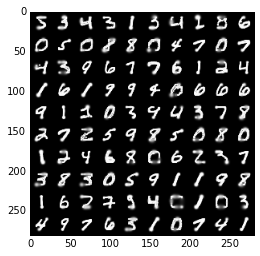

In [8]:
X = capsule.preprocess(data.train.X[0:nb_examples])
xx = X.copy()
xx = xx.transpose((0, 2, 3, 1)) * np.ones((1, 1, 1, 3))
source = dispims_color(xx, border=0)

    
y = encode(X)

imgs = []
for t in range(y.shape[1]):
    yy = y[:, t]
    yy = yy[:, :, :, None] * np.ones((1, 1, 1, 3))
    yy = sigmoid(yy+bias)
    img = dispims_color(yy, border=0)
    plt.imshow(img)
    imgs.append(img)

seq_imgs = imgs

In [ ]:
X = capsule.preprocess(data.train.X[0:nb_examples])
y = encode_coords(X)

imgs = []
canvas = []
for t in range(y.shape[1]):
    
    gx, gy = y[:, t, 0], y[:, t, 1]
    gx = sigmoid(gx) * w_out
    gy = sigmoid(gy) * h_out
    img = np.zeros((y.shape[0], w_out, h_out))
    if len(canvas):
        img = canvas[-1]
    for i in range(y.shape[0]):
        img[i, gx[i] - 1, gy[i] - 1] = 1
    
    canvas.append(img)

    img = dispims_color(img[:, :, :, None] * np.ones((1, 1, 1, 3)), bordercolor=(255, 255, 255))
    imgs.append(img)
seq_pointer = imgs

In [9]:
# you want just imgs

imgs = seq_imgs

# you want just pointers

#imgs = seq_pointer

# you want both

#imgs = []
#for img, ptr in zip(seq_imgs, seq_pointer):
#    imgs.append(concat_imgs(img, ptr))

## Make a video and an image

In [10]:
imgs = [np.zeros_like(imgs[0])] + imgs
img_aggreg = np.zeros((img.shape[0], img.shape[1]*2, 3))
img_aggreg[0:source.shape[0], 0:source.shape[1]] = source
img_aggreg[:, source.shape[1]:source.shape[1]+img.shape[1]] = img
imsave('out.png', img_aggreg)

/home/mcherti/miniconda/envs/databoard-env/lib/python2.7/site-packages/skimage/util/dtype.py:111: UserWarning: Possible precision loss when converting from float64 to uint8
  "%s to %s" % (dtypeobj_in, dtypeobj))


In [11]:
import os
if os.path.exists('out.mp4'):
    os.remove('out.mp4')
imgs_to_video(imgs, out='out.mp4', verbose=1, framerate=8, rate=8)

/home/mcherti/miniconda/envs/databoard-env/lib/python2.7/site-packages/skimage/io/_io.py:159: UserWarning: /tmp/img_to_videoZZdC5t/img00000000.png is a low contrast image
  warnings.warn('%s is a low contrast image' % fname)


ffmpeg -framerate 8 -i img%08d.png -c:v libx264 -r 8 -pix_fmt yuv420p /home/mcherti/work/code/feature_generation/ipynb/out.mp4


In [13]:
from IPython.display import HTML

def embed_video(filename):
    return HTML("""
        <video width="320" height="240" controls>
        <source src="out.mp4" type="video/mp4">
        </video>
        """.format(filename))
embed_video('out.mp4')